In [1]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torchvision import datasets, transforms

In [2]:
data_path = 'Data/Images' #looking in subfolder train

scream_dataset = datasets.ImageFolder(
    root=data_path,
    transform=transforms.Compose([transforms.Resize((64,862)),
                                  transforms.ToTensor()])
)
scream_dataset

Dataset ImageFolder
    Number of datapoints: 3544
    Root location: Data/Images
    StandardTransform
Transform: Compose(
               Resize(size=(64, 862), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [3]:
class_map=scream_dataset.class_to_idx

print("\nClass category and index of the images: {}\n".format(class_map))


Class category and index of the images: {'not': 0, 'scream': 1}



In [4]:
#split data to test and train
#use 80% to train
train_size = int(0.8 * len(scream_dataset))
test_size = len(scream_dataset) - train_size
scream_train_dataset, scream_test_dataset = torch.utils.data.random_split(scream_dataset, [train_size, test_size])

print("Training size:", len(scream_train_dataset))
print("Testing size:",len(scream_test_dataset))

Training size: 2835
Testing size: 709


In [5]:
from collections import Counter

# labels in training set
train_classes = [label for _, label in scream_train_dataset]
Counter(train_classes)

Counter({0: 2111, 1: 724})

In [7]:
train_dataloader = torch.utils.data.DataLoader(
    scream_train_dataset,
    batch_size=64,
    num_workers=2,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    scream_test_dataset,
    batch_size=64,
    num_workers=2,
    shuffle=True
)

In [8]:
td = train_dataloader.dataset[0][0]
td

tensor([[[0.2000, 0.6471, 0.5137,  ..., 0.8118, 0.8118, 0.7490],
         [0.7294, 0.7294, 0.5843,  ..., 0.8314, 0.8235, 0.6980],
         [0.6235, 0.7725, 0.6353,  ..., 0.8039, 0.8039, 0.6784],
         ...,
         [0.1569, 0.2824, 0.2784,  ..., 0.2824, 0.2824, 0.1569],
         [0.1569, 0.2824, 0.2824,  ..., 0.2824, 0.2824, 0.1569],
         [0.1569, 0.2784, 0.2784,  ..., 0.2784, 0.2745, 0.1569]],

        [[0.7137, 0.8549, 0.8275,  ..., 0.8824, 0.8824, 0.8745],
         [0.8706, 0.8706, 0.8431,  ..., 0.8824, 0.8824, 0.8667],
         [0.8510, 0.8745, 0.8549,  ..., 0.8784, 0.8784, 0.8627],
         ...,
         [0.4824, 0.1098, 0.1529,  ..., 0.1176, 0.1255, 0.4784],
         [0.4784, 0.1255, 0.1294,  ..., 0.1255, 0.1176, 0.4784],
         [0.4784, 0.0588, 0.0667,  ..., 0.0824, 0.0549, 0.4784]],

        [[0.4745, 0.2078, 0.2941,  ..., 0.1098, 0.1098, 0.1412],
         [0.1529, 0.1529, 0.2471,  ..., 0.1020, 0.1059, 0.1725],
         [0.2196, 0.1294, 0.2157,  ..., 0.1137, 0.1137, 0.

In [9]:
td.shape

torch.Size([3, 64, 862])

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [11]:
from torchvision.models import resnet34
import torch

model = resnet34(pretrained=True)
model.fc = nn.Linear(512,2)
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
model = model.to(device)

C:\Users\eddie\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\eddie\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# cost function used to determine best parameters
cost = torch.nn.CrossEntropyLoss()

# used to create optimal parameters
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

# Create the training function

def train(dataloader, model, loss, optimizer):
    model.train()
    size = len(dataloader.dataset)
    correct = 0  # Counter for correct predictions
    total = 0  # Counter for total examples

    for batch, (X, Y) in enumerate(dataloader):

        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = cost(pred, Y)
        loss.backward()
        optimizer.step()

        # Compute accuracy
        _, predicted = pred.max(1)
        total += Y.size(0)
        correct += predicted.eq(Y).sum().item()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]  Train Accuracy: {(100 * correct / total):.2f}%')


# Create the validation/test function

def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            pred = model(X)

            test_loss += cost(pred, Y).item()
            correct += (pred.argmax(1)==Y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    print(f'\nTest Error:\nacc: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}\n')
    return test_loss

In [13]:
# Define the early stopping parameters
early_stopping_patience = 15  # Number of epochs to wait before early stopping
best_loss = torch.inf
wait = 0  # Counter for patience
epochs = 150

best_model_weights = None

# Training loop
for t in range(epochs):
    print(f'Epoch {t + 1}\n-------------------------------')
    train(train_dataloader, model, cost, optimizer)
    test_loss = test(test_dataloader, model)

    # Check if the test loss has improved
    if test_loss < best_loss:
        best_loss = test_loss
        wait = 0  # Reset patience

        # Save the best model weights
        best_model_weights = model.state_dict()
    else:
        wait += 1

    if wait >= early_stopping_patience:
        print("Early stopping triggered. No improvement in test loss for {} epochs.".format(early_stopping_patience))
        break  # Stop training

# Restore the best model weights
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)

print('Done!')

Epoch 1
-------------------------------
loss: 0.617827  [    0/ 2835]  Train Accuracy: 65.62%
loss: 0.576579  [  640/ 2835]  Train Accuracy: 76.28%
loss: 0.443220  [ 1280/ 2835]  Train Accuracy: 77.68%
loss: 0.404635  [ 1920/ 2835]  Train Accuracy: 79.18%
loss: 0.429366  [ 2560/ 2835]  Train Accuracy: 79.27%

Test Error:
acc: 86.2%, avg loss: 0.006457

Epoch 2
-------------------------------
loss: 0.334044  [    0/ 2835]  Train Accuracy: 85.94%
loss: 0.307825  [  640/ 2835]  Train Accuracy: 83.24%
loss: 0.300307  [ 1280/ 2835]  Train Accuracy: 83.48%
loss: 0.567328  [ 1920/ 2835]  Train Accuracy: 83.72%
loss: 0.259164  [ 2560/ 2835]  Train Accuracy: 84.87%

Test Error:
acc: 86.9%, avg loss: 0.005303

Epoch 3
-------------------------------
loss: 0.271759  [    0/ 2835]  Train Accuracy: 89.06%
loss: 0.457978  [  640/ 2835]  Train Accuracy: 87.50%
loss: 0.359004  [ 1280/ 2835]  Train Accuracy: 86.53%
loss: 0.338054  [ 1920/ 2835]  Train Accuracy: 86.44%
loss: 0.360473  [ 2560/ 2835]  Tra

In [14]:
import torch
from datetime import datetime

# Get the current timestamp in the desired format
timestamp = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

# Define the file name with the timestamp
file_name = f"Resnet34_Model_{timestamp}.pt"

# Save the entire model (including architecture and weights)
torch.save(model, file_name)

# Print the saved file name
print(f"Model saved as {file_name}")

Model saved as Resnet34_Model_2023-10-13--17-11-18.pt


In [6]:
# Load the model's state_dict
model = torch.load('Resnet34_Model_2023-10-13--17-11-18.pt')

In [7]:
from torchsummary import summary

# Assuming 'model' is your PyTorch model
summary(model, input_size=(3, 64, 862))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 32, 431]           9,408
       BatchNorm2d-2          [-1, 64, 32, 431]             128
              ReLU-3          [-1, 64, 32, 431]               0
         MaxPool2d-4          [-1, 64, 16, 216]               0
            Conv2d-5          [-1, 64, 16, 216]          36,864
       BatchNorm2d-6          [-1, 64, 16, 216]             128
              ReLU-7          [-1, 64, 16, 216]               0
            Conv2d-8          [-1, 64, 16, 216]          36,864
       BatchNorm2d-9          [-1, 64, 16, 216]             128
             ReLU-10          [-1, 64, 16, 216]               0
       BasicBlock-11          [-1, 64, 16, 216]               0
           Conv2d-12          [-1, 64, 16, 216]          36,864
      BatchNorm2d-13          [-1, 64, 16, 216]             128
             ReLU-14          [-1, 64, 

In [8]:
import os
import torchaudio
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def pad_waveform(waveform, target_length):
    num_channels, current_length = waveform.shape

    if current_length < target_length:
        # Calculate the amount of padding needed
        padding = target_length - current_length
        # Pad the waveform with zeros on the right side
        waveform = torch.nn.functional.pad(waveform, (0, padding))

    return waveform

# Define a function to transform audio data into images
def transform_data_to_image(audio, sample_rate, label, i):
    # Pad waveform to a consistent length of 44100 samples
    audio = pad_waveform(audio, 441000)

    spectrogram_tensor = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=64, n_fft=1024)(audio)[0] + 1e-10

    # Save the spectrogram as an image
    image_path = f'Data/TestImages/{label}/image{i}.png'

    plt.imsave(image_path, spectrogram_tensor.log2().numpy(), cmap='viridis')
    return image_path

# Define the image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((64, 862)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:3, :, :])
])

In [11]:
import pandas as pd

# Define the folder containing WAV files
folder_path = 'Data/Screaming'  # Replace with the path to your folder
label = 'Screaming'  # Label for the images

# Create an empty list to store data
predictions_data = []

# Iterate through WAV files in the folder
for i, filename in enumerate(os.listdir(folder_path)):
    if filename.endswith('.wav'):
        # Load the audio
        audio, sample_rate = torchaudio.load(os.path.join(folder_path, filename))

        # Transform audio to an image and save it
        image_path = transform_data_to_image(audio, sample_rate, label, i)

        # Load the saved image and apply transformations
        image = Image.open(image_path)
        image = transform(image).unsqueeze(0)  # Add batch dimension

        # Make predictions using the model
        model.eval()
        with torch.no_grad():
            outputs = model(image.to(device))

        predict = outputs.argmax(dim=1).cpu().detach().numpy().ravel()[0]

        # Store the filename and prediction in the DataFrame
        predictions_data.append({'Filename': filename, 'Prediction': predict})

# Create a DataFrame from the list of data
scream_predictions_df = pd.DataFrame(predictions_data)

# Display the DataFrame with predictions
scream_predictions_df

,Filename,Prediction
0,---1_cCGK4M_out.wav,1
1,-20uudT97E0_out.wav,0
2,-2yygHLdpXc_out.wav,1
3,-3bGlOhRkAo_out.wav,1
4,-4pUrlMafww_out.wav,1
...,...,...
857,_QMEw67gWIA_out.wav,1
858,_TLzbbay6Hw_out.wav,1
859,_XPPISqmXSE_out.wav,1
860,_xRpsu02t9o_out.wav,1


In [12]:
scream_predictions_df['Prediction'].value_counts()

Prediction
1    824
0     38
Name: count, dtype: int64

In [13]:
# Define the folder containing WAV files
folder_path = 'Data/NotScreaming'  # Replace with the path to your folder
label = 'NotScreaming'  # Label for the images
import pandas as pd

# Create an empty list to store data
predictions_data = []

# Iterate through WAV files in the folder
for i, filename in enumerate(os.listdir(folder_path)):
    if filename.endswith('.wav'):
        # Load the audio
        audio, sample_rate = torchaudio.load(os.path.join(folder_path, filename))

        # Transform audio to an image and save it
        image_path = transform_data_to_image(audio, sample_rate, label, i)

        # Load the saved image and apply transformations
        image = Image.open(image_path)
        image = transform(image).unsqueeze(0)  # Add batch dimension

        # Make predictions using the model
        model.eval()
        with torch.no_grad():
            outputs = model(image.to(device))

        predict = outputs.argmax(dim=1).cpu().detach().numpy().ravel()[0]

        # Store the filename and prediction in the DataFrame
        predictions_data.append({'Filename': filename, 'Prediction': predict})

# Create a DataFrame from the list of data
not_scream_predictions_df = pd.DataFrame(predictions_data)

# Display the DataFrame with predictions
not_scream_predictions_df

,Filename,Prediction
0,--PJHxphWEs_out.wav,0
1,-28U1_qW0sU_out.wav,0
2,-4xJv59_zcA_out.wav,0
3,-5GhUbDLYkQ_out.wav,0
4,-5Jlimvsuwo_out.wav,0
...,...,...
2626,_XusTa2prSw_out.wav,0
2627,_y07ENAx2_E_out.wav,0
2628,_yqlQimkHpQ_out.wav,0
2629,_Zsk5Fxqbkc_out.wav,0


In [14]:
not_scream_predictions_df['Prediction'].value_counts()

Prediction
0    2556
1      75
Name: count, dtype: int64

In [15]:
# Compute TP, FP, TN, FN for Scream predictions
scream_TP = scream_predictions_df['Prediction'].value_counts().get(1, 0)
scream_FN = scream_predictions_df['Prediction'].value_counts().get(0, 0)
scream_samples = len(scream_predictions_df)

# Compute TP, FP, TN, FN for Not Scream predictions
scream_TN = not_scream_predictions_df['Prediction'].value_counts().get(0, 0)
scream_FP = not_scream_predictions_df['Prediction'].value_counts().get(1, 0)
not_scream_samples = len(not_scream_predictions_df)

# Calculate total samples
total_samples = scream_samples + not_scream_samples

In [16]:
# Calculate accuracy
accuracy = (scream_TP + scream_TN) / total_samples

# Calculate precision
precision = scream_TP / (scream_TP + scream_FP)

# Calculate recall
recall = scream_TP / (scream_TP + scream_FN)

# Calculate F1 score
f1 = 2 * (precision * recall) / (precision + recall)

# Print the results
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Accuracy: 0.97
Precision: 0.92
Recall: 0.96
F1 Score: 0.94


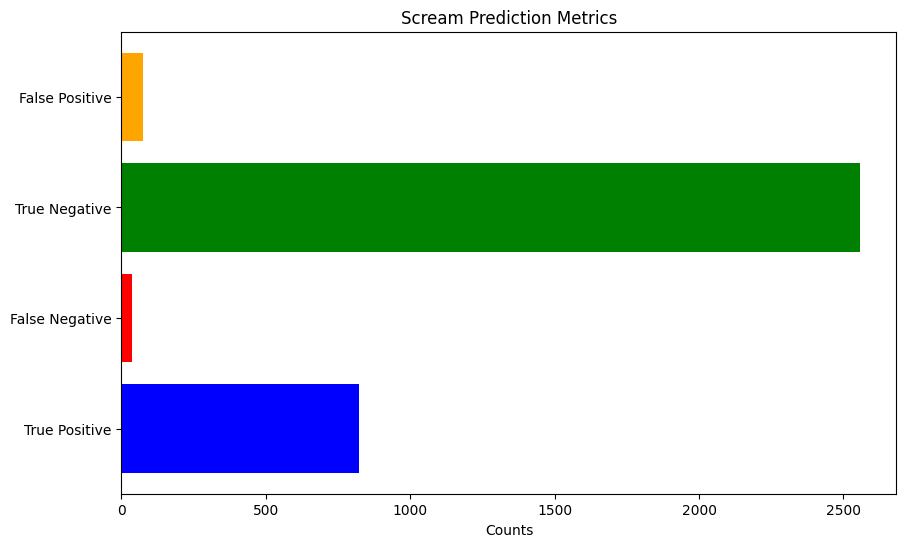

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Labels and values
labels = ['True Positive', 'False Negative', 'True Negative', 'False Positive']
values = [scream_TP, scream_FN, scream_TN, scream_FP]

# Create bar chart
plt.figure(figsize=(10, 6))
plt.barh(labels, values, color=['blue', 'red', 'green', 'orange'])
plt.xlabel('Counts')
plt.title('Scream Prediction Metrics')
plt.show()

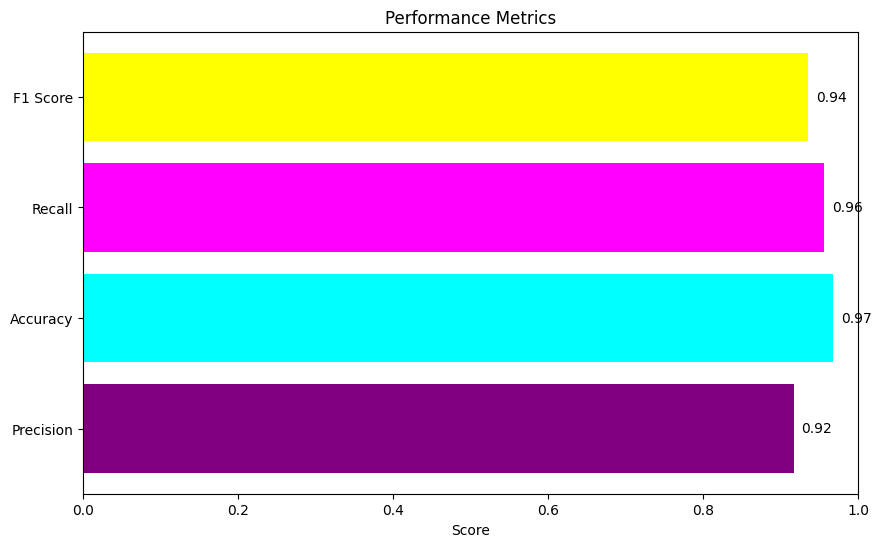

In [22]:
# Labels and values for plotting
score_labels = ['Precision', 'Accuracy', 'Recall', 'F1 Score']
score_values = [precision, accuracy, recall, f1]

# Create bar chart for the scores
plt.figure(figsize=(10, 6))
plt.barh(score_labels, score_values, color=['purple', 'cyan', 'magenta', 'yellow'])
plt.xlabel('Score')
plt.title('Performance Metrics')
plt.xlim(0, 1)  # Scores range between 0 and 1
for i, v in enumerate(score_values):
    plt.text(v + 0.01, i, f"{v:.2f}", color='black', verticalalignment='center')
plt.show()